<font size=4 >First load the required libraries.</font>

In [142]:
import numpy as np
import pandas as pd
import datetime
import random

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor

from sklearn.linear_model import Ridge, RidgeCV
from xgboost import XGBRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

from sklearn.pipeline import make_pipeline

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings(action="ignore")

load and view data
===

In [143]:
# Read Data form local file path
all_final_df = pd.read_csv("all_final_df.csv")

In [144]:
# Display the data shape
all_final_df.shape

(2919, 34)

In [145]:
# Display the first five rows of data
all_final_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Neighborhood,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinType1,BsmtFinSF1,BsmtUnfSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,FullBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,OpenPorchSF,SalePrice,TotalSqFeet
0,60,RL,65.0,8450,CollgCr,7,5,4,3,4,3,GLQ,706.0,150.0,GasA,5,Y,SBrkr,856,2,3,1,4,8,Typ,Attchd,RFn,2.0,548.0,3,3,61,208500.0,2566.0
1,20,RL,80.0,9600,Veenker,6,8,3,3,4,3,ALQ,978.0,284.0,GasA,5,Y,SBrkr,1262,2,3,1,3,6,Typ,Attchd,RFn,2.0,460.0,3,3,0,181500.0,2524.0
2,60,RL,68.0,11250,CollgCr,7,5,4,3,4,3,GLQ,486.0,434.0,GasA,5,Y,SBrkr,920,2,3,1,4,6,Typ,Attchd,RFn,2.0,608.0,3,3,42,223500.0,2706.0
3,70,RL,60.0,9550,Crawfor,7,5,3,3,3,4,ALQ,216.0,540.0,GasA,4,Y,SBrkr,961,1,3,1,4,7,Typ,Detchd,Unf,3.0,642.0,3,3,35,140000.0,2473.0
4,60,RL,84.0,14260,NoRidge,8,5,4,3,4,3,GLQ,655.0,490.0,GasA,5,Y,SBrkr,1145,2,4,1,4,9,Typ,Attchd,RFn,3.0,836.0,3,3,84,250000.0,3343.0


5.Data cleaning
===

5.1 Data Standardization
---

In [146]:
# Filter out all properties of numeric type
numeric_cols = all_final_df.columns[all_final_df.dtypes!='object']
numeric_cols

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtFinSF1',
       'BsmtUnfSF', 'HeatingQC', '1stFlrSF', 'FullBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'GarageCars',
       'GarageArea', 'GarageQual', 'GarageCond', 'OpenPorchSF', 'SalePrice',
       'TotalSqFeet'],
      dtype='object')

In [147]:
# Calculate data normalization
numeric_col_means = all_final_df.loc[:,numeric_cols].mean()
numeric_col_max = all_final_df.loc[:,numeric_cols].max()
numeric_col_min = all_final_df.loc[:,numeric_cols].min()
numeric_col_std = all_final_df.loc[:,numeric_cols].std()
numeric_col_sum = all_final_df.loc[:,numeric_cols].sum()

norm = 'min_max'
if norm == 'z_score':
    # Z_Score
    all_final_df.loc[:,numeric_cols] = (all_final_df.loc[:,numeric_cols] - numeric_col_means)/numeric_col_std
elif norm == 'min_max':
    # Min_Max
    all_final_df.loc[:,numeric_cols] = (all_final_df.loc[:,numeric_cols] - numeric_col_min)/(numeric_col_max-numeric_col_min)
elif norm == 'DecimalScaling':
    # DecimalScaling
    p = numeric_col_max//10 if numeric_col_max % 10 == 0 else numeric_col_max // 10 + 1
    #all_dummy_df.loc[:,numeric_cols] = all_dummy_df.loc[:,numeric_cols]/(math.pow(10,p))
elif norm == 'Mean':
    # Mean
    all_final_df.loc[:,numeric_cols] = (all_final_df.loc[:,numeric_cols] - numeric_col_means) / (numeric_col_max - numeric_col_min)
elif norm == 'Vector':
    # Vector
    all_final_df.loc[:,numeric_cols] = all_final_df.loc[:,numeric_cols] / numeric_col_sum
elif norm == 'lg':
    # lg
    all_final_df.loc[:,numeric_cols] = all_final_df.loc[:,numeric_cols].apply(np.log)/ numeric_col_max.apply(np.log)
elif norm == 'SoftMax':
    # SoftMax
    all_final_df.loc[:,numeric_cols] = all_final_df.loc[:,numeric_cols].apply(np.exp) / all_final_df.loc[:,numeric_cols].apply(np.exp).sum()
elif norm == 'Sigmoid':
    # Sigmoid
    all_final_df.loc[:,numeric_cols] = 1 / (1 + (0-all_final_df.loc[:,numeric_cols]).apply(np.exp))
                                        
print(all_final_df.loc[:,numeric_cols])

      MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  ExterQual  \
0       0.235294     0.150685  0.033420     0.666667        0.500   0.666667   
1       0.000000     0.202055  0.038795     0.555556        0.875   0.333333   
2       0.235294     0.160959  0.046507     0.666667        0.500   0.666667   
3       0.294118     0.133562  0.038561     0.666667        0.500   0.333333   
4       0.235294     0.215753  0.060576     0.777778        0.500   0.666667   
...          ...          ...       ...          ...          ...        ...   
2914    0.823529     0.000000  0.002973     0.333333        0.750   0.333333   
2915    0.823529     0.000000  0.002776     0.333333        0.500   0.333333   
2916    0.000000     0.476027  0.087406     0.444444        0.750   0.333333   
2917    0.382353     0.140411  0.042726     0.444444        0.500   0.333333   
2918    0.235294     0.181507  0.038921     0.666667        0.500   0.333333   

      ExterCond  BsmtQual  BsmtCond  Bs

<font size=4 >Uniformly perform one-hot processing on all the string data in the data to facilitate fitting.</font>

In [148]:
# Process all values whose attributes are strings into one-hot form
all_dummy_df = pd.get_dummies(all_final_df)
all_dummy_df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinSF1,BsmtUnfSF,HeatingQC,1stFlrSF,FullBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,GarageCars,GarageArea,GarageQual,GarageCond,OpenPorchSF,SalePrice,TotalSqFeet,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageFinish_Fin,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf
0,0.235294,0.150685,0.033420,0.666667,0.500,0.666667,0.5,0.8,0.75,0.125089,0.064212,1.00,0.109641,0.50,0.375,0.333333,0.666667,0.461538,0.4,0.368280,0.6,0.6,0.082210,0.241078,0.195481,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0
1,0.000000,0.202055,0.038795,0.555556,0.875,0.333333,0.5,0.8,0.75,0.173281,0.121575,1.00,0.194917,0.50,0.375,0.333333,0.333333,0.307692,0.4,0.309140,0.6,0.6,0.000000,0.203583,0.191802,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0
2,0.235294,0.160959,0.046507,0.666667,0.500,0.666667,0.5,0.8,0.75,0.086109,0.185788,1.00,0.123083,0.50,0.375,0.333333,0.666667,0.307692,0.4,0.408602,0.6,0.6,0.056604,0.261908,0.207742,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0
3,0.294118,0.133562,0.038561,0.666667,0.500,0.333333,0.5,0.6,1.00,0.038271,0.231164,0.75,0.131695,0.25,0.375,0.333333,0.666667,0.384615,0.6,0.431452,0.6,0.6,0.047170,0.145952,0.187336,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1
4,0.235294,0.215753,0.060576,0.777778,0.500,0.666667,0.5,0.8,0.75,0.116052,0.209760,1.00,0.170342,0.50,0.500,0.333333,0.666667,0.538462,0.6,0.561828,0.6,0.6,0.113208,0.298709,0.263531,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0


5.2 Process data for model preparation
---

<font size=4 >Displaying the distribution of the target data, it can be seen that it conforms to the characteristics of a normal distribution, but the variance of the data is too large.</font>

<font size=4 >It is processed by log1p to make its distribution closer to the standard normal distribution, as shown in the right figure.</font>

array([[<Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'log(price+1)'}>]], dtype=object)

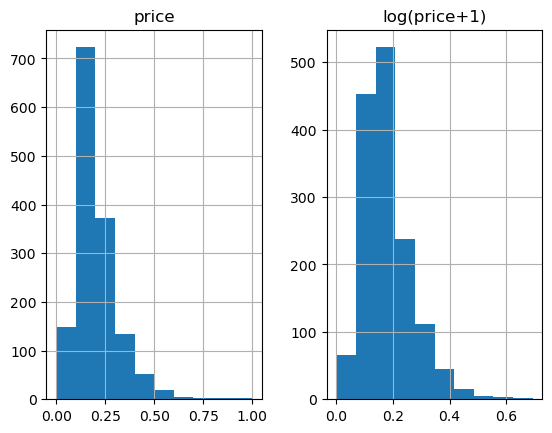

In [149]:
# Smooth the SalePrice data using log1p
prices = pd.DataFrame({"price":all_final_df["SalePrice"],"log(price+1)":np.log1p(all_final_df["SalePrice"])})
prices.hist()

In [150]:
# After the data processing is completed, the data is re-divided into train and test parts
dummy_train_df = all_dummy_df.loc[0:1459,:]
dummy_test_df = all_dummy_df.loc[1460:2918,:]

In [151]:
dummy_train_df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinSF1,BsmtUnfSF,HeatingQC,1stFlrSF,FullBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,GarageCars,GarageArea,GarageQual,GarageCond,OpenPorchSF,SalePrice,TotalSqFeet,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageFinish_Fin,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf
0,0.235294,0.150685,0.033420,0.666667,0.500,0.666667,0.5,0.8,0.75,0.125089,0.064212,1.00,0.109641,0.50,0.375,0.333333,0.666667,0.461538,0.4,0.368280,0.6,0.6,0.082210,0.241078,0.195481,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0
1,0.000000,0.202055,0.038795,0.555556,0.875,0.333333,0.5,0.8,0.75,0.173281,0.121575,1.00,0.194917,0.50,0.375,0.333333,0.333333,0.307692,0.4,0.309140,0.6,0.6,0.000000,0.203583,0.191802,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0
2,0.235294,0.160959,0.046507,0.666667,0.500,0.666667,0.5,0.8,0.75,0.086109,0.185788,1.00,0.123083,0.50,0.375,0.333333,0.666667,0.307692,0.4,0.408602,0.6,0.6,0.056604,0.261908,0.207742,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0
3,0.294118,0.133562,0.038561,0.666667,0.500,0.333333,0.5,0.6,1.00,0.038271,0.231164,0.75,0.131695,0.25,0.375,0.333333,0.666667,0.384615,0.6,0.431452,0.6,0.6,0.047170,0.145952,0.187336,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1
4,0.235294,0.215753,0.060576,0.777778,0.500,0.666667,0.5,0.8,0.75,0.116052,0.209760,1.00,0.170342,0.50,0.500,0.333333,0.666667,0.538462,0.6,0.561828,0.6,0.6,0.113208,0.298709,0.263531,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0


In [152]:
dummy_train_df.shape,dummy_test_df.shape

((1460, 93), (1459, 93))

In [153]:
dummy_train_df.SalePrice.isnull().sum()

0

In [154]:
dummy_test_df.SalePrice.isnull().sum()

1459

In [155]:
# Extract training target data from raw data
y_train = dummy_train_df.pop('SalePrice')

In [156]:
y_train.head()

0    0.241078
1    0.203583
2    0.261908
3    0.145952
4    0.298709
Name: SalePrice, dtype: float64

In [157]:
# View missing values 
y_train.isnull().sum()

0

6.Model linear fit
===

<font size=4 >First, I compared the Ridge, Random Forest, Lasso and XGBoost models as target models and fitted the processed data separately.</font>

<font size=4 >Within the three models, I iterated through the corresponding hyperparameters to adjust the model parameters for the best results. During the iteration process, I chose cross-validation as a method to evaluate the model's scores and error rates. By plotting the curves of hyperparameters and cross-validation scores, it can be observed that the model fitting results can be locally optimized to the best.</font>



<font size=4 >Ridge Regression</font>

In [158]:
# Extract the input of the model
X_train = dummy_train_df.values
X_test = dummy_test_df.values

In [159]:
# Use the cross validation method that comes with Sklearn to test the model
alphas = np.logspace(-3,0.5,50)
test_scores = []
error_min = 1
best_alpha = 0

for alpha in alphas:
    clf = Ridge(alpha)
    #print(alpha)
    test_score = np.mean(np.sqrt(-cross_val_score(clf,X_train,y_train,cv=10,scoring='neg_mean_squared_error')))
    #print(test_score)
    test_scores.append(test_score)
    if test_score < error_min:
        error_min = test_score
        best_alpha = alpha
print(error_min,best_alpha)

0.044371602358549124 0.2682695795279725


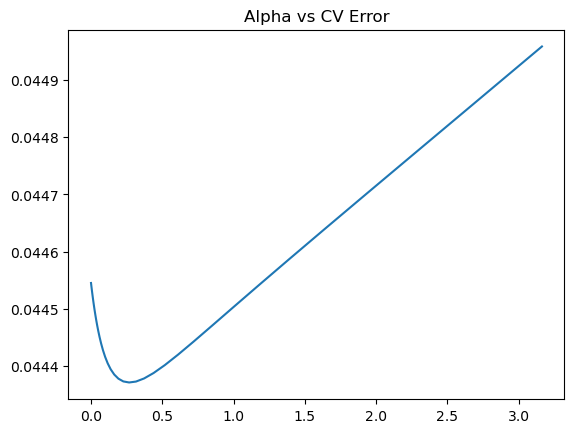

In [160]:
# The visualized results show the error curves under different hyperparameters
plt.plot(alphas,test_scores)
plt.title("Alpha vs CV Error");

<font size=4 >Random Forest</font>

In [161]:
# Use the cross validation method that comes with Sklearn to test the model
max_features = np.arange(0.1,0.99,0.05)
test_scores = []
error_min = 1
best_feat = 0

for max_feat in max_features:
    clf = RandomForestRegressor(n_estimators=100, max_features=max_feat)
    test_score = np.mean(np.sqrt(-cross_val_score(clf,X_train,y_train,cv=5,scoring='neg_mean_squared_error')))
    test_scores.append(test_score)
    #test_score
    if test_score < error_min:
        error_min = test_score
        best_feat = max_feat
print(error_min,best_feat)

0.038750907419999314 0.40000000000000013


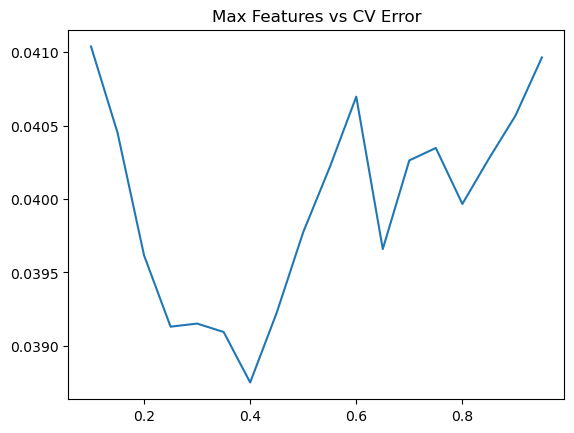

In [162]:
# The visualized results show the error curves under different hyperparameters
plt.plot(max_features,test_scores)
plt.title("Max Features vs CV Error");

<font size=4 >Lasso</font>

In [163]:
# Use the cross validation method that comes with Sklearn to test the model
from sklearn.linear_model import LinearRegression, Lasso

alphas = np.logspace(-5,0,50)
test_scores = []
error_min = 1
best_feat = 0

for alpha in alphas:    
    clf = Lasso(alpha)
    #print(alpha)
    test_score = np.mean(np.sqrt(-cross_val_score(clf,X_train,y_train,cv=10,scoring='neg_mean_squared_error')))
    #print(test_score)
    test_scores.append(test_score)
    if test_score < error_min:
        error_min = test_score
        best_alpha = alpha
print(error_min,best_feat)

0.04416937223371095 0


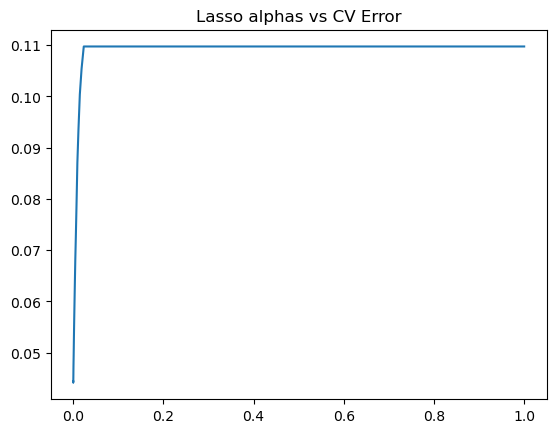

In [164]:
# The visualized results show the error curves under different hyperparameters
plt.plot(alphas,test_scores)
plt.title("Lasso alphas vs CV Error");

In [165]:
# Use the best parameters of the model to fit the results
Lasso = Lasso(alpha=0.1)

In [166]:
Lasso.fit(X_train,y_train)

Lasso(alpha=0.1)

<font size=4 >XGBoost</font>

In [167]:
# Setup cross validation folds
kf = KFold(n_splits=12, random_state=42, shuffle=True)

In [168]:
train_labels = dummy_train_df['MSSubClass'].reset_index(drop=True)

In [169]:
# Define error metrics
def rmsle(y, y_train):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X_train):
    rmse = np.sqrt(-cross_val_score(model, X, train_labels, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

In [170]:
xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=6000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:linear',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)

In [171]:
scores = {}
score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['xgb'] = (score.mean(), score.std())

[17:07:20] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[17:07:29] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[17:07:38] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[17:07:48] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[17:07:57] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[17:08:06] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linea